In [3]:
#Optimal compression ratio based on the features in the compressed images

In [112]:
#pip install opencv-python
import cv2
import os
import numpy as np
import time
from numpy import polyfit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from PIL import Image

In [74]:
def sift(image):
    """
    image is assumed to be grayscale
    """
    #Initiate the SIFT detector
    sift=cv2.SIFT.create()

    #Find keypoints and descriptors
    keypoints,descriptors=sift.detectAndCompute(image,None)

    #Draw keypoints on the image
    image_with_sift=cv2.drawKeypoints(image.copy(),keypoints,None,(255,0,0),4)

    return keypoints,image_with_sift

def surf(image):
    """
    image assumed to be gray
    """
    surf=cv2.xfeatures2d.SURF_create()

    keypoints,descriptors=surf.detectAndCompute(image,None)

    image_with_surf=cv2.drawKeypoints(image.copy(),keypoints,None,(0,255,0),4)

    return keypoints,image_with_surf

def fast(image):
    """
    image assumed to be gray
    """
    fast=cv2.FastFeatureDetector_create()

    keypoints=fast.detect(image,None)

    image_with_fast=cv2.drawKeypoints(image.copy(),keypoints,None,(0,0,255),4)

    return keypoints,image_with_fast

def harris_corner_detection(image):
    """
    image assumed to be gray
    """
    #Apply Harris Corner detection
    dst=np.float32(image)
    dst=cv2.cornerHarris(image,2,3,0.04)
    dst=cv2.dilate(dst,None)

    #Threshold and identify corners
    ret,dst=cv2.threshold(dst,0.1*dst.max(),255,0)
    dst=np.uint8(dst)

    #find centroids of corners
    ret,labels,*_=cv2.connectedComponentsWithStats(dst) #syntax unpacks any remaining values into a throwaway variable
    centroids=[]
    for i in range(1,labels.shape[0]):
        r,c=np.where(labels==i)
         # Ensure there are valid coordinates before calculating means
        if r.size > 0 and c.size > 0:
            centroids.append((np.mean(c), np.mean(r)))
        #centroids.append((np.mean(c),np.mean(r)))

    # Draw corners on the image
    if centroids:  # Check if any centroids were found
        keypoints = [cv2.KeyPoint(x, y,size=1) for x, y in centroids]
        image_with_corners = cv2.drawKeypoints(image.copy(), keypoints, None, (0, 0, 255), 4)
    else:
    # Handle the case where no corners are found (optional: return empty list/image)
        image_with_corners = image.copy()  # Or create a placeholder image

    return centroids,image_with_corners

def shi_tomasi(image):
    """
        Image assumed to be gray.
    """
    corners = cv2.goodFeaturesToTrack(image, 100, 0.01, 10)

  # Handle cases where corners might not be a NumPy array or empty
    if len(corners.shape) == 1:
        corners = corners.reshape(-1, 2)  # Reshape if 1D array

    if corners.any() and all(isinstance(val, (int, float)) for val in corners.flatten()):
        keypoints = [cv2.KeyPoint(x, y) for x, y in corners]
        image_with_shi_tomasi = cv2.drawKeypoints(image.copy(), keypoints, None, (255, 255, 0), 4)
    else:
    # Handle case where no corners are detected or unexpected data type
        keypoints = []
        image_with_shi_tomasi = image.copy()  # Or create a placeholder image
    # Consider logging a warning here
    
    return corners, image_with_shi_tomasi

def orb(image):
    orb=cv2.ORB_create()
    keypoints,descriptors=orb.detectAndCompute(image,None)

    return keypoints,descriptors

def brisk(image):
    brisk=cv2.xfeatures2d.BRISK_create()
    keypoints,descriptors=brisk.detectAndCompute(image,None)
    return keypoints,descriptors

    
algorithms=["sift","fast","harris_corner_detection","shi_tomasi","orb"]    

In [75]:
def feature_detection_comparison(img_path):
    """
    Compare the number of features and the time for detection of each feature detection algorithm
    """
    #load the image in the grayscale
    img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)

    results={}
    
    for algo in algorithms:
        start=time.time()
        keypoints,image=globals()[algo](img)
        end=time.time()
        results[algo]=(len(keypoints),end-start)

    print(results)
   

In [100]:
#comparing the features
path=r'C:\Swapnil\Narrowband_DRONE\Drone_dataset_small_1\New folder\New folder'
images=file_handling(path)

img_path=os.path.join(path,images[0])
feature_detection_comparison(img_path)

# compress the image
img=Image.open(img_path)
quality=[10,20,30,40,50,60,70,80,90,100]

for q in quality:
    export_name=images[0].split('.')[0]+"_"+str(q)+".webp"
    img.save(os.path.join(path,export_name),format="WEBP",quality=q)

images=file_handling(path)
print(images)
fast_res={}

#testing for fast only
for image in images:
    img_path=os.path.join(path,image)
    img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    start=time.time()
    keypoints,image_=fast(img)
    end=time.time()
    fast_res[image]=[len(keypoints),round(end-start,2)]

sift_res={}
#testing sift
for image in images:
    img_path=os.path.join(path,image)
    img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    start=time.time()
    keypoints,image_=sift(img)
    end=time.time()
    sift_res[image]=[len(keypoints),round(end-start,2)]



In path: C:\Swapnil\Narrowband_DRONE\Drone_dataset_small_1\New folder\New folder
Files: 12
Images are in format: jpg count: 11
{'sift': (4887, 0.307664155960083), 'fast': (70773, 0.13939356803894043), 'harris_corner_detection': (30, 4.272587299346924), 'shi_tomasi': (100, 0.03251791000366211), 'orb': (500, 0.02351236343383789)}
In path: C:\Swapnil\Narrowband_DRONE\Drone_dataset_small_1\New folder\New folder
Files: 12
Images are in format: jpg count: 11
['0300.jpg', '0300_10.webp', '0300_100.webp', '0300_20.webp', '0300_30.webp', '0300_40.webp', '0300_50.webp', '0300_60.webp', '0300_70.webp', '0300_80.webp', '0300_90.webp']


In [126]:
#print(fast_res)
print("FAST")
values=list(fast_res.values())
org=0
for i,j in enumerate(images):
    size=os.path.getsize(os.path.join(path,j))/1000
    fast_res[j].append(size)
    if j.endswith('.jpg'):
        org_f=size
        features_f=values[i][0]
    CR=round(org_f/size,2)
    fast_res[j].append(CR)
    print(i,j,size,values[i][0],"CR:",CR)


print()
print("SIFT")
values_=list(sift_res.values())
org=0
for i,j in enumerate(images):
    size=os.path.getsize(os.path.join(path,j))/1000
    sift_res[j].append(size)
    if j.endswith('.jpg'):
        org_s=size
        features_s=values_[i][0]
    CR=round(org_s/size,2)
    sift_res[j].append(CR)
    print(i,j,size,values_[i][0],"CR:",CR)

print(features_s,features_f)

FAST
0 0300.jpg 845.767 70773 CR: 1.0
1 0300_10.webp 47.766 14253 CR: 17.71
2 0300_100.webp 962.826 69135 CR: 0.88
3 0300_20.webp 76.802 22093 CR: 11.01
4 0300_30.webp 109.322 36862 CR: 7.74
5 0300_40.webp 143.984 48713 CR: 5.87
6 0300_50.webp 184.504 59366 CR: 4.58
7 0300_60.webp 221.478 62699 CR: 3.82
8 0300_70.webp 257.594 63399 CR: 3.28
9 0300_80.webp 353.42 69561 CR: 2.39
10 0300_90.webp 581.57 71130 CR: 1.45

SIFT
0 0300.jpg 845.767 4887 CR: 1.0
1 0300_10.webp 47.766 3559 CR: 17.71
2 0300_100.webp 962.826 4858 CR: 0.88
3 0300_20.webp 76.802 4244 CR: 11.01
4 0300_30.webp 109.322 4204 CR: 7.74
5 0300_40.webp 143.984 4215 CR: 5.87
6 0300_50.webp 184.504 4294 CR: 4.58
7 0300_60.webp 221.478 4450 CR: 3.82
8 0300_70.webp 257.594 4568 CR: 3.28
9 0300_80.webp 353.42 4670 CR: 2.39
10 0300_90.webp 581.57 4828 CR: 1.45
4887 70773


[845.767, 47.766, 962.826, 76.802, 109.322, 143.984, 184.504, 221.478, 257.594, 353.42, 581.57]
[70773, 14253, 69135, 22093, 36862, 48713, 59366, 62699, 63399, 69561, 71130]
org: 845.767 70773


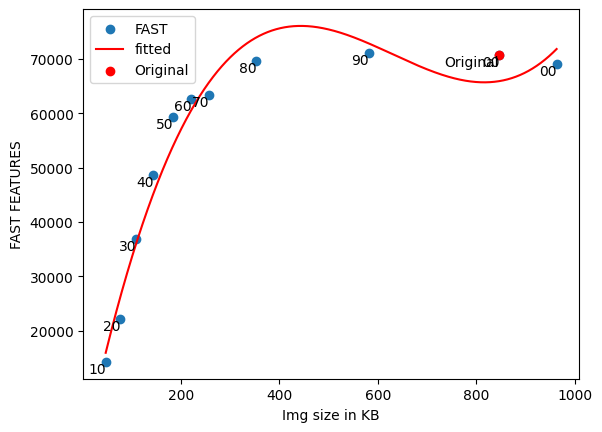

In [200]:
#print(values)
fast_features=[features[0] for features in values]
img_size=[features[2] for features in values]

sift_features=[features[0] for features in values_]
#img_size=[features[2] for features in values]

print(img_size)
print(fast_features)
p=polyfit(img_size,fast_features,3)
x_fit=np.linspace(min(img_size),max(img_size),10000)
y_fit=p[0]*x_fit**3 +p[1]*x_fit**2+ p[2]*x_fit + p[3]
plt.scatter(img_size,fast_features,label="FAST")
plt.plot(x_fit,y_fit,label="fitted",color="red")
print("org:",org_f,features_f)
plt.scatter(org_f,features_f,marker='o',color='red',label="Original")
for i in range(len(fast_features)):
    label_text=images[i].split('.')[0][-2:]
    label_obj=plt.text(img_size[i]+0.5,fast_features[i]+0.5,label_text,ha='right',va='top',fontsize=10)
label_obj=plt.text(org_f+0.5,features_f+0.5,"Original",ha='right',va='top',fontsize=10)
plt.xlabel("Img size in KB")
plt.ylabel("FAST FEATURES")
plt.legend()
fig_path=os.path.join(path,"Fast_features.png")
plt.savefig(fig_path,dpi=300,bbox_inches='tight')
plt.show()

[[4887, 0.3, 845.767, 1.0, 845.767, 1.0, 845.767, 1.0], [3559, 0.3, 47.766, 17.71, 47.766, 17.71, 47.766, 17.71], [4858, 0.3, 962.826, 0.88, 962.826, 0.88, 962.826, 0.88], [4244, 0.29, 76.802, 11.01, 76.802, 11.01, 76.802, 11.01], [4204, 0.29, 109.322, 7.74, 109.322, 7.74, 109.322, 7.74], [4215, 0.27, 143.984, 5.87, 143.984, 5.87, 143.984, 5.87], [4294, 0.28, 184.504, 4.58, 184.504, 4.58, 184.504, 4.58], [4450, 0.31, 221.478, 3.82, 221.478, 3.82, 221.478, 3.82], [4568, 0.3, 257.594, 3.28, 257.594, 3.28, 257.594, 3.28], [4670, 0.31, 353.42, 2.39, 353.42, 2.39, 353.42, 2.39], [4828, 0.31, 581.57, 1.45, 581.57, 1.45, 581.57, 1.45]]
[845.767, 47.766, 962.826, 76.802, 109.322, 143.984, 184.504, 221.478, 257.594, 353.42, 581.57]
[4887, 3559, 4858, 4244, 4204, 4215, 4294, 4450, 4568, 4670, 4828]


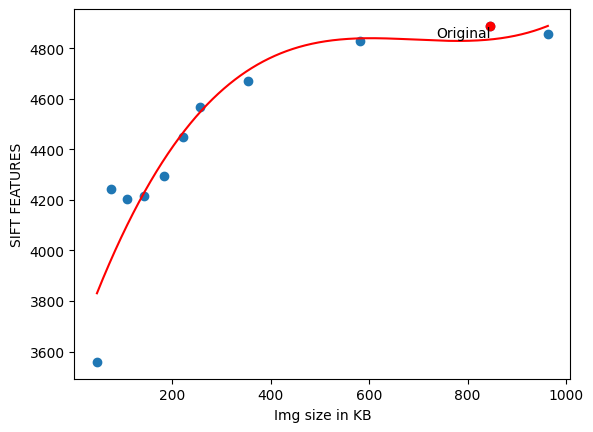

In [153]:
print(values_)
sift_features=[features[0] for features in values_]
img_size=[features[2] for features in values]
print(img_size)
print(sift_features)
p=polyfit(img_size,sift_features,3)
x_fit=np.linspace(min(img_size),max(img_size),10000)
y_fit=p[0]*x_fit**3 +p[1]*x_fit**2+ p[2]*x_fit + p[3]
plt.scatter(img_size,sift_features,label="SIFT")
plt.scatter(org_s,features_s,marker='o',color='red',label="Original")
label_obj=plt.text(org_s+0.5,features_s+0.5,"Original",ha='right',va='top',fontsize=10)
#label_obj.set_bbox(dict(facecolor='white', edgecolor='black', pad=0.2))
plt.plot(x_fit,y_fit,label="fitted",color="red")
fig_path=os.path.join(path,"Sift_features.png")
plt.savefig(fig_path,dpi=300,bbox_inches='tight')
plt.xlabel("Img size in KB")
plt.ylabel("SIFT FEATURES")
plt.show()

In [22]:
def detect_features(img_path,display=False):
    """
        I/P: path of image
        O/P: number of features detected
    """
    #load the image in grayscale
    img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)

    #Shi-Tomasi corner detection parameters
    maxCorners=20000 #maximum number of corners to detect
    qualityLevel=0.01 #quality level for corner selection
    minDistance=10 #Min distance between the corners

    #Perform corner detection 
    corners=cv2.goodFeaturesToTrack(img,maxCorners,qualityLevel,minDistance)
    #print("Corners:",corners)
    if display==True:
        if corners is not None:
            for corner in corners:
                x,y=corner.ravel()
                radius=2
                cv2.circle(img,(int(x),int(y)),radius,(255,0,0),-1) #draw red circle
        cv2.imshow("image with features",img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    #count the number of detected features
    num_features=len(corners) if corners is not None else 0

    return num_features




In [23]:
dataset_path=r'C:\Swapnil\Narrowband_DRONE\Drone_dataset_small_1'


def file_handling(path):

    files=os.listdir(path)
    print("In path:",path)
    print("Files:",len(files))
    images=[]
    image_formats=[".jpg",".jpeg",".png",".webp",".avif"]
    for file in files:
        if file.lower().endswith(tuple(image_formats)):
            images.append(file)
    if len(images)!=0:
        print("Images are in format:",images[0].split('.')[1],"count:",len(images))
    return images

images=file_handling(dataset_path)
img_path=os.path.join(dataset_path,images[0])
start=time.time()
num_features=detect_features(img_path)
end=time.time()
print("Features count:",num_features,"in",round(end-start,2),"seconds")

In path: C:\Swapnil\Narrowband_DRONE\Drone_dataset_small_1
Files: 7
Images are in format: jpg count: 4
Features count: 1821 in 0.04 seconds


In [18]:
#features distributions

def evaluate_image_for_sfm(image_path, feature_detector=cv2.xfeatures2d.SIFT_create(), min_distance=10):
  """
  Analyzes an image for its suitability for Structure from Motion (SfM).

  Args:
      image_path (str): Path to the image file.
      feature_detector (cv2.FeatureDetector, optional): OpenCV feature detector object (default SIFT).
      min_distance (int, optional): Minimum distance between features (default 10).

  Returns:
      dict: Dictionary containing metrics related to SfM suitability:
          - total_features (int): Total number of detected features.
          - empty_cells (int): Number of empty cells in the feature distribution grid.
          - occupied_cells (int): Number of occupied cells in the feature distribution grid.
          - grid_entropy (float): Entropy of the feature distribution grid.
          - average_harris_corner_strength (float): Average strength of Harris corners.
          - distinctiveness_score (float): Combined metric for SfM suitability.

  Raises:
      ValueError: If the feature detector is not a subclass of cv2.FeatureDetector.
  """

  # Load the image in grayscale
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # Validate feature detector type
  if not isinstance(feature_detector, cv2.FeatureDetector):
    raise ValueError("feature_detector must be a subclass of cv2.FeatureDetector")

  # Detect features
  keypoints = feature_detector.detect(img, None)

  # Calculate image dimensions
  image_height, image_width = img.shape[:2]

  # Create an empty grid to store feature counts
  grid_width = image_width // 10  # Adjust as needed
  grid_height = image_height // 10  # Adjust as needed
  grid = np.zeros((grid_height, grid_width), dtype=int)

  # Assign features to grid cells
  for kp in keypoints:
    x, y = int(kp.pt[0]), int(kp.pt[1])
    grid_x = x // grid_width
    grid_y = y // grid_height
    grid[grid_y, grid_x] += 1

  # Feature distribution metrics
  total_features = len(keypoints)
  empty_cells = np.count_nonzero(grid == 0)
  occupied_cells = grid.size - empty_cells
  grid_entropy = calculate_grid_entropy(grid)  # Function defined below

  # Harris corner analysis (optional, adjust weights as needed)
  harris_corners = cv2.cornerHarris(img, 2, 3, 0.04)  # Parameters for Harris corner detection
  average_harris_corner_strength = np.mean(harris_corners)

  # Distinctiveness score (combine metrics with weights)
  distinctiveness_score = (0.5 * total_features) + (0.2 * (1 - empty_cells / grid.size)) + (0.3 * average_harris_corner_strength)

  # Return dictionary with metrics
  return {
      "total_features": total_features,
      "empty_cells": empty_cells,
      "occupied_cells": occupied_cells,
      "grid_entropy": grid_entropy,
      "average_harris_corner_strength": average_harris_corner_strength,
      "distinctiveness_score": distinctiveness_score
  }


def calculate_grid_entropy(grid):
  """
  Calculates the entropy of the feature distribution grid.

  Args:
      grid (np.ndarray): Feature distribution grid (2D array of integer counts).

  Returns:
      float: Entropy of the grid distribution.
  """

  p_grid = grid.astype(np.float64) / np.sum(grid)  # Normalize grid to probabilities
  p_grid[p_grid == 0] = 1e-9  # Avoid log(0) errors
  return -np.sum(p_grid * np.log2(p_grid))  # Calculate entropy

# Example usage
image_path = img_path
dct=evaluate_image_for_sfm(image_path)
print(dct)




AttributeError: module 'cv2' has no attribute 'FeatureDetector'

COLMAP uses SIFT Feature matching and feature detection in its SFM process
-SIFT offers robustness to the scale, rotation, illumination changes and some degree of noise 
-Good performance of SIFT for SFM tasks

In [190]:
#feature matching using SIFT

def feature_matching(img_path_1,img_path_2):

    img1=cv2.imread(img_path_1,cv2.IMREAD_GRAYSCALE)
    img2=cv2.imread(img_path_2,cv2.IMREAD_GRAYSCALE)

    #initialize the SIFT detector
    sift=cv2.SIFT_create()

    #Find Keypoints and descriptors
    kp1,des1=sift.detectAndCompute(img1,None)
    kp2,des2=sift.detectAndCompute(img2,None)
    print(len(kp2))
    
    #Create FLANN matcher (fast library for approximate nearest neighbors)
    bf=cv2.BFMatcher()

    #Match keypoints between images
    matches=bf.match(des1,des2)
    print(matches[0],matches[0].distance)
    #print(matches)

    #good matches
    good_matches=[]
    lowes_ratio=0.7
    if isinstance(matches,list):
        for m,n in matches:
            if m.distance<lowes_ratio*n.distance:
                good_matches.append(m)
    else:
        if matches.distance<lowes_ratio*matches.distance:
            good_matches.append(matches)
    print("good_matches:",len(good_matches))

    matches=sorted(matches,key=lambda val: val.distance)
    out = cv2.drawMatches(img1, kp1, img2, kp2, matches[:500], None, flags=2)
    plt.imshow(out), plt.show()
    if len(kp1)>0:
        percent_matching=(len(matches)/len(kp1))*100
        print(f"Percent of Matching keypoints:{percent_matching:.2f}%")
    
    
path_test=r'C:\Swapnil\Narrowband_DRONE\Drone_dataset_small_1\New folder'
img_path_1=os.path.join(path_test,"0381.jpg")
img_path_2=os.path.join(path_test,"0388.jpg")
feature_matching(img_path_1,img_path_2)

7983
< cv2.DMatch 0000018409F936F0> 311.3020935058594


AttributeError: 'tuple' object has no attribute 'distance'